# Regime switching Hidden Markov model

This example replicates the [case study](http://modernstatisticalworkflow.blogspot.com/2018/02/regime-switching-models-in-stan.html) analyzing financial time series, specifically the daily difference in log price data of Google's stock, referred to as returns $r_t$.

We'll assume that at any given time $t$ the stock's returns will follow one of two regimes: an independent random walk regime where $r_t \sim \mathcal{N}(\alpha_1, \sigma^2_1)$ and an autoregressive regime where $r_t \sim \mathcal{N}(\alpha_2 + \rho r_{t-1}, \sigma_2^2)$. Being on either of the two regimes, $s_t\in \{0, 1\}$, will depend on the previous time's regime $s_{t-1}$, call these probabilities $p_{s_{t-1}, s_{t}}$ for $s_{t-1}, s_t \in \{0, 1\}$. Set as parameters of the model $p_{1,1}$ and $p_{2,2}$ and define the complementary probabilities by definition: $p_{1,2} = 1-p_{1,1}$ and $p_{2,1} = 1-p_{2,2}$. Since the regime at any time is unobserved, we instead carry over time the probability of belonging to either one regime as $\xi_{1t} + \xi_{2t} = 1$. Finally, we need to model initial values, both for returns $r_0$ and probability of belonging to one of the two regimes $\xi_{10}$.

In the whole, our regime-switching model is defined by the likelihood

```{math}
\begin{split}
    L(\mathbf{r}|\alpha, \rho, \sigma^2, \mathbf{p}, r_0, \xi_{10}) &= \prod_t \xi_{1t}\eta_{1t} + (1-\xi_{1t})\eta_{2t} \\
    \xi_{1t} &= \frac{\xi_{1t-1}\eta_{1t}}{\xi_{1t-1}\eta_{1t} + (1-\xi_{1t-1})\eta_{2t}},
\end{split}
```

where $\eta_{jt} = p_{j,1}$, $\mathcal{N}(r_t;\alpha_1, \sigma_1^2) + p_{j,2}$, and $\mathcal{N}(r_t; \alpha_2 + \rho r_{t-1}, \sigma_2^2)$ for $j\in\{0, 1\}$. And the priors of the parameters are:

```{math}
\begin{split}
    \alpha_1, \alpha_2 &\sim \mathcal{N}(0, 1) \\
    \rho &\sim \mathcal{N}^0(1, 0.1) \\
    \sigma_1, \sigma_2 &\sim \mathcal{C}^+(1) \\
    p_{1,1}, p_{2,2} &\sim \mathcal{Beta}(10, 2) \\
    r_0 &\sim \mathcal{N}(0, 1) \\
    \xi_{10} &\sim \mathcal{Beta}(2, 2),
\end{split}
```

where $\mathcal{N}^0$ indicates the truncated at 0 Gaussian distribution and $\mathcal{C}^+$ the half-Cauchy distribution.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as distrib
import pandas as pd
import seaborn as sns
from jax.scipy.stats import norm
from numpyro.diagnostics import print_summary
from numpyro.infer.util import initialize_model

import blackjax


class RegimeMixtureDistribution(distrib.Distribution):
    arg_constraints = {
        "alpha": distrib.constraints.real,
        "rho": distrib.constraints.positive,
        "sigma": distrib.constraints.positive,
        "p": distrib.constraints.interval(0, 1),
        "xi_0": distrib.constraints.interval(0, 1),
        "y_0": distrib.constraints.real,
        "T": distrib.constraints.positive_integer,
    }
    support = distrib.constraints.real

    def __init__(self, alpha, rho, sigma, p, xi_0, y_0, T, validate_args=True):
        self.alpha, self.rho, self.sigma, self.p, self.xi_0, self.y_0, self.T = (
            alpha,
            rho,
            sigma,
            p,
            xi_0,
            y_0,
            T,
        )
        super().__init__(event_shape=(T,), validate_args=validate_args)

    def log_prob(self, value):
        def obs_t(carry, y):
            y_prev, xi_1 = carry
            eta_1 = norm.pdf(y, loc=self.alpha[0], scale=self.sigma[0])
            eta_2 = norm.pdf(
                y, loc=self.alpha[1] + y_prev * self.rho, scale=self.sigma[1]
            )
            lik_1 = self.p[0] * eta_1 + (1 - self.p[0]) * eta_2
            lik_2 = (1 - self.p[1]) * eta_1 + self.p[1] * eta_2
            lik = xi_1 * lik_1 + (1 - xi_1) * lik_2
            lik = jnp.clip(lik, a_min=1e-6)
            return (y, xi_1 * lik_1 / lik), jnp.log(lik)

        _, log_liks = jax.lax.scan(obs_t, (self.y_0, self.xi_0), value)
        return jnp.sum(log_liks)

    def sample(self, key, sample_shape=()):
        return jnp.zeros(sample_shape + self.event_shape)


class RegimeSwitchHMM:
    def __init__(self, T, y) -> None:
        self.T = T
        self.y = y

    def model(self, y=None):
        rho = numpyro.sample("rho", distrib.TruncatedNormal(1.0, 0.1, low=0.0))
        alpha = numpyro.sample("alpha", distrib.Normal(0.0, 0.1).expand([2]))
        sigma = numpyro.sample("sigma", distrib.HalfCauchy(1.0).expand([2]))
        p = numpyro.sample("p", distrib.Beta(10.0, 2.0).expand([2]))
        xi_0 = numpyro.sample("xi_0", distrib.Beta(2.0, 2.0))
        y_0 = numpyro.sample("y_0", distrib.Normal(0.0, 1.0))

        numpyro.sample(
            "obs",
            RegimeMixtureDistribution(alpha, rho, sigma, p, xi_0, y_0, self.T),
            obs=y,
        )

    def initialize_model(self, rng_key, n_chain):

        (init_params, *_), self.potential_fn, *_ = initialize_model(
            rng_key,
            self.model,
            model_kwargs={"y": self.y},
            dynamic_args=True,
        )
        kchain = jax.random.split(rng_key, n_chain)
        flat, unravel_fn = jax.flatten_util.ravel_pytree(init_params)
        self.init_params = jax.vmap(
            lambda k: unravel_fn(jax.random.normal(k, flat.shape))
        )(kchain)
        self.init_params = {
            name: 1.0 + value if name in ["p", "sigma"] else value
            for name, value in self.init_params.items()
        }
        # self.init_params = {name: 3. + value if name in ['sigma'] else value for name, value in self.init_params.items()}

    def logdensity_fn(self, params):
        return -self.potential_fn(self.y)(params)


def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

In [2]:
url = "https://raw.githubusercontent.com/blackjax-devs/blackjax/main/docs/examples/data/google.csv"
data = pd.read_csv(url)
y = data.dl_ac.values * 100
T, _ = data.shape

In [3]:
dist = RegimeSwitchHMM(T, y)

In [4]:
[n_chain, n_warm, n_iter] = [128, 5000, 200]
ksam, kinit = jrnd.split(jrnd.PRNGKey(0), 2)
dist.initialize_model(kinit, n_chain)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
tic1 = pd.Timestamp.now()
k_warm, k_sample = jrnd.split(ksam)
warmup = blackjax.meads_adaptation(dist.logdensity_fn, n_chain)
(init_state, parameters), _ = warmup.run(k_warm, dist.init_params, n_warm)
kernel = blackjax.ghmc(dist.logdensity_fn, **parameters).step

def one_chain(k_sam, init_state):
    state, info = inference_loop(k_sam, init_state, kernel, n_iter)
    return state.position, info

k_sample = jrnd.split(k_sample, n_chain)
samples, infos = jax.vmap(one_chain)(k_sample, init_state)
tic2 = pd.Timestamp.now()
print("Runtime for MEADS", tic2 - tic1)

Runtime for MEADS 0 days 00:00:27.301532


In [6]:
print_summary(samples)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]      0.06      0.08      0.06     -0.07      0.21   1642.52      1.09
  alpha[1]      0.01      0.10      0.01     -0.16      0.17    743.11      1.12
      p[0]      2.69      0.40      2.67      1.95      3.29   1150.87      1.12
      p[1]      1.82      0.87      1.74      0.40      3.17   1780.60      1.08
       rho     -0.05      0.40     -0.01     -0.19      0.16     70.25      3.85
  sigma[0]      1.05      0.09      1.04      0.97      1.12     87.25      2.06
  sigma[1]      2.14      0.26      2.13      1.86      2.46    123.59      1.52
      xi_0      0.53      1.01      0.47     -1.12      2.14   1325.46      1.10
       y_0     -0.01      0.99     -0.00     -1.60      1.61   1900.53      1.06



In [7]:
samples = jax.tree_map(lambda s: s.reshape((-1,) + s.shape[2:]), samples)

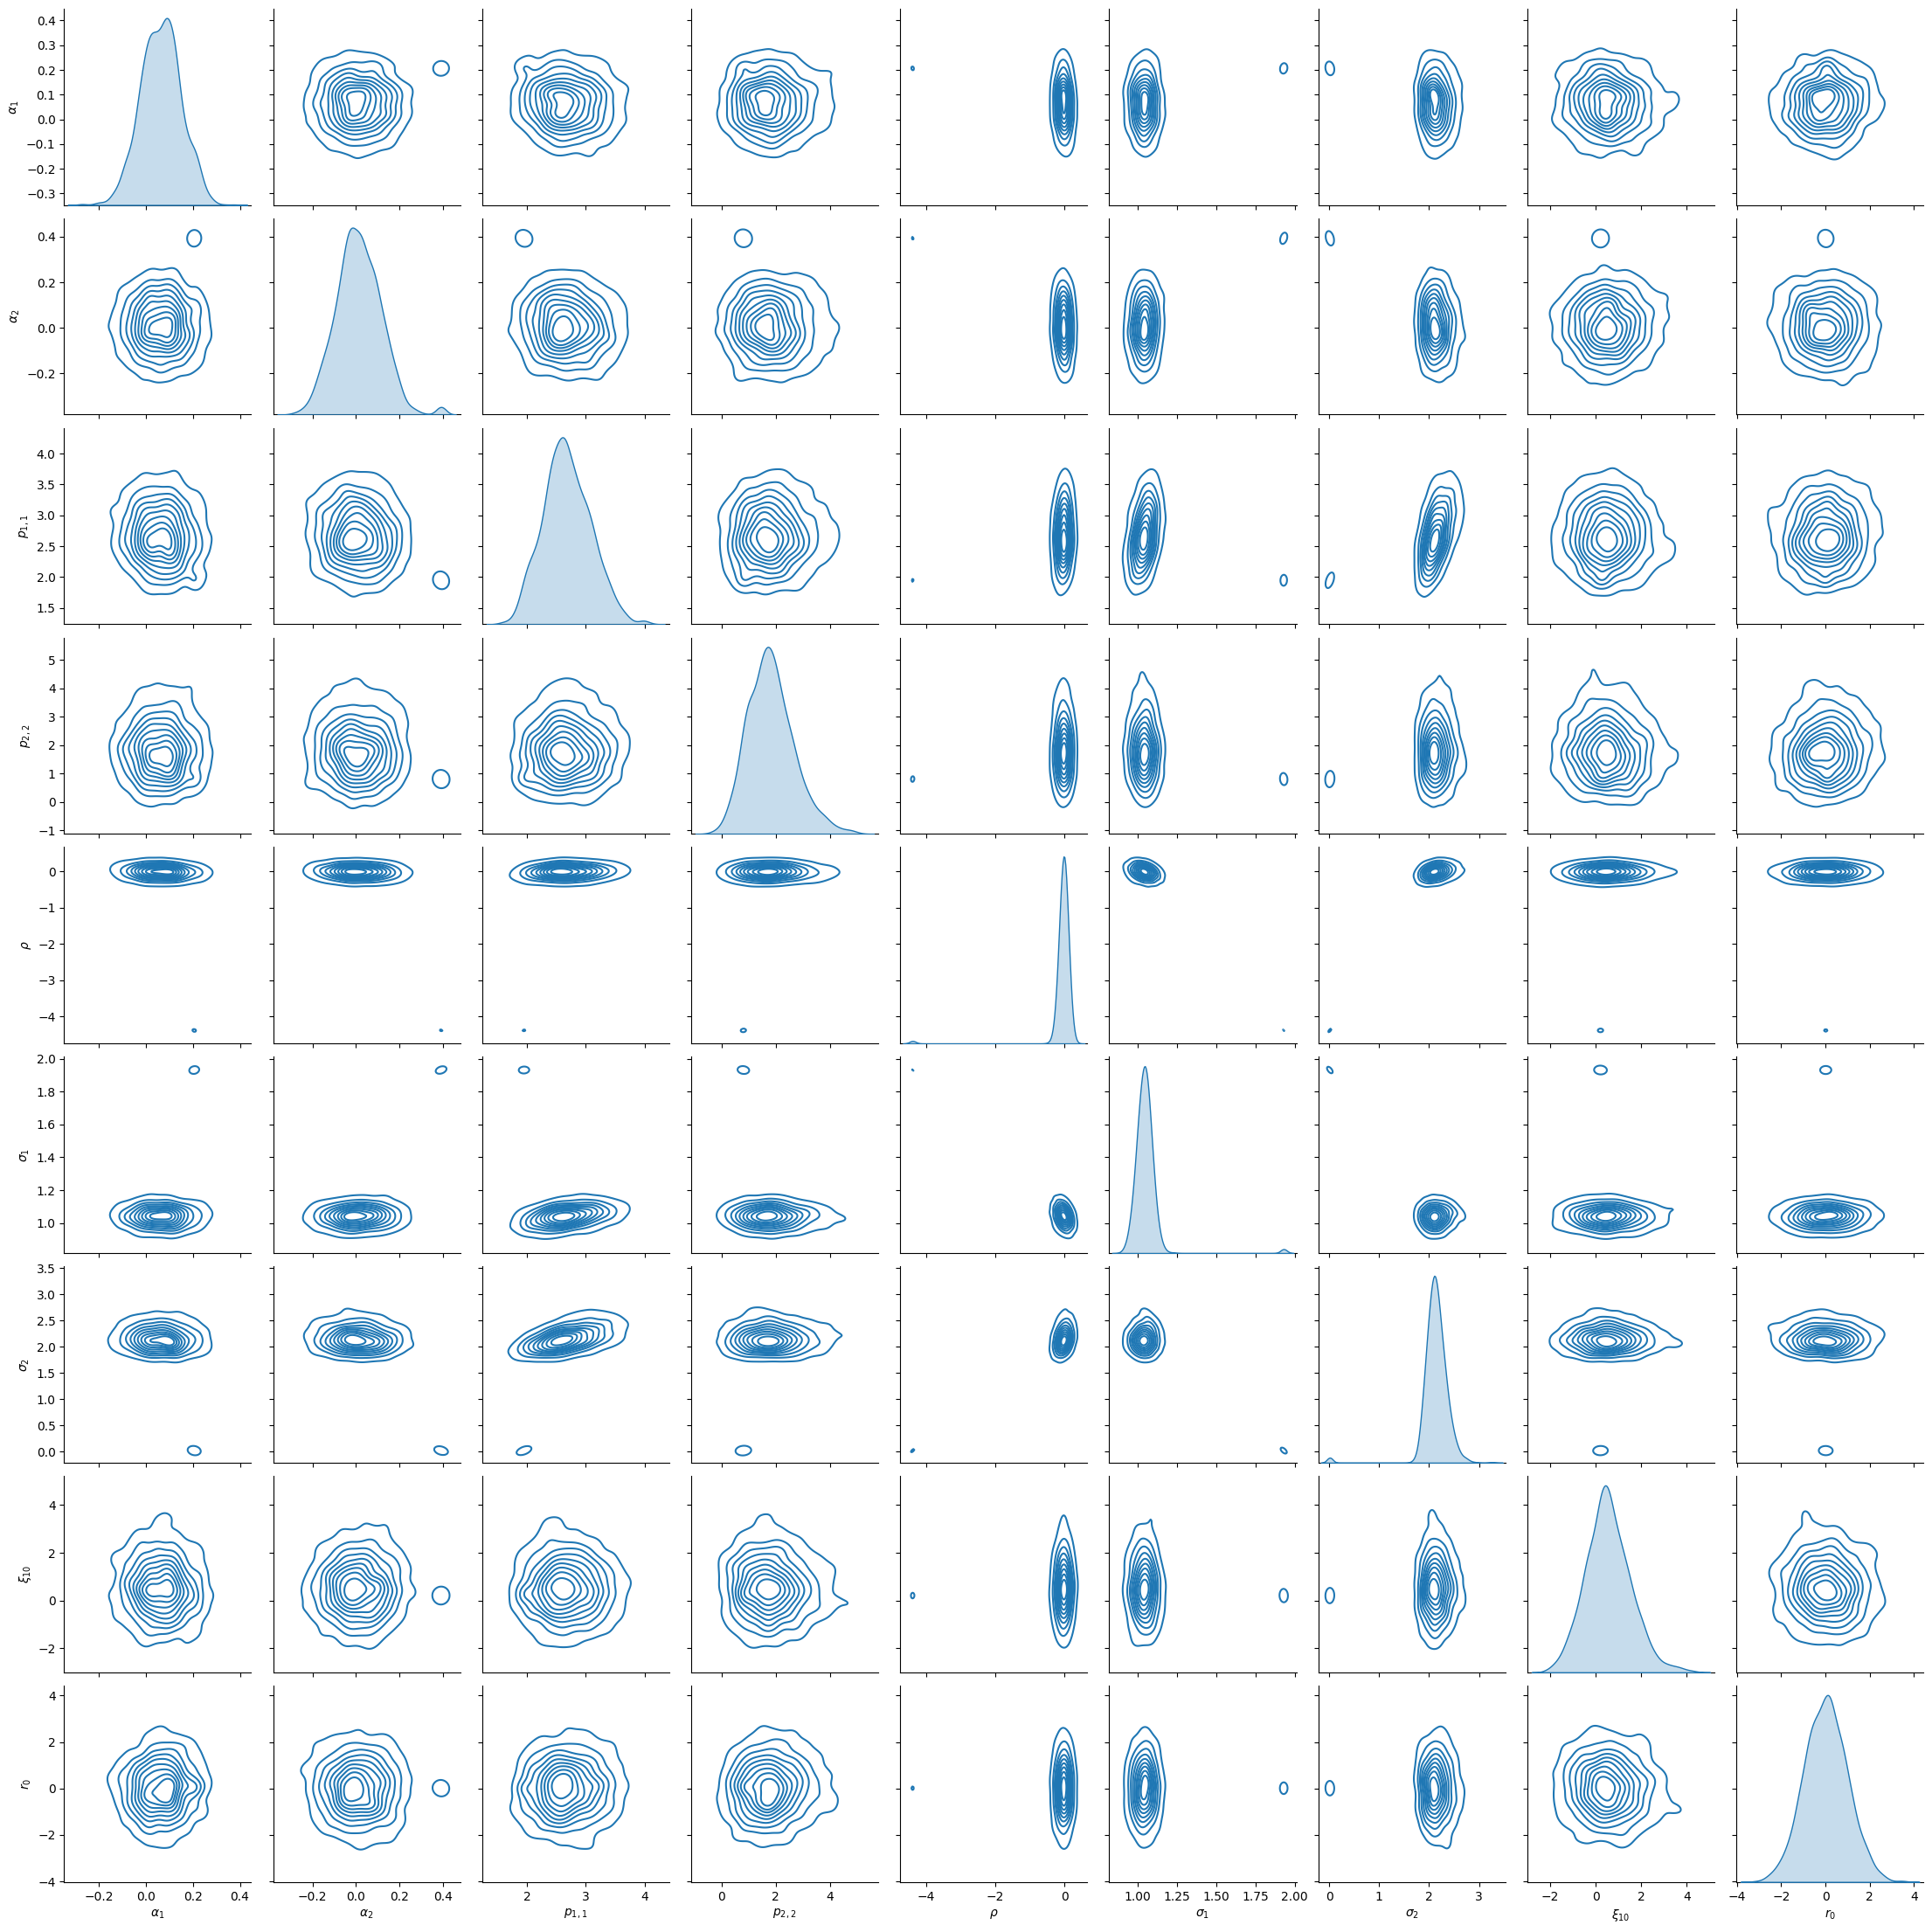

In [8]:
sam = []
for name, value in samples.items():
    sam.append(np.asarray(value).T)
columns = [
    r"$\alpha_1$",
    r"$\alpha_2$",
    r"$p_{1,1}$",
    r"$p_{2,2}$",
    r"$\rho$",
    r"$\sigma_1$",
    r"$\sigma_2$",
    r"$\xi_{10}$",
    r"$r_0$",
]
df = pd.DataFrame(np.vstack(sam).T, columns=columns)
sns.pairplot(df.sample(2000), kind="kde", diag_kind="kde")
plt.show()